<a href="https://colab.research.google.com/github/Krishna-Kumar-Sankaran-Kutty/PersonalFinanceUtils/blob/main/GetMFData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dependencies

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

# Function to extract MF Portfolio Holdings data from Money Control

Define function to extract portfolio details from given url from Moneycontrol Portfolio Holdings page

In [ ]:
def extract_portfolio(url):
  # Send an HTTP GET request to the URL
  response = requests.get(url)

  # Parse the HTML content using BeautifulSoup
  soup = BeautifulSoup(response.content, 'html.parser')

  # Find the table element
  table = soup.find('table', id='equityCompleteHoldingTable')

  # Extract table headers
  headers = [header.text.strip() for header in table.find_all('th')]

  # Extract table rows
  rows = []
  for row in table.find_all('tr')[1:]:  # Skip the header row
    data = [cell.text.strip() for cell in row.find_all('td')]
    rows.append(data)

  # Create a Pandas DataFrame
  df = pd.DataFrame(rows, columns=headers)

  # Add Fund Name column
  df['Fund Name'] = url.split('/')[-3].replace('-', ' ').title()

  # Set Fund Name column as index
  df = df.set_index('Fund Name')

  # Clean-up 'Stock Invested in' column
  df['Stock Invested in'] = df['Stock Invested in'].str.replace('#\n', '')

  # Clean-up '% of Total Holdings' column nad convert to float
  df['% of Total Holdings'] = df['% of Total Holdings'].str.rstrip('%').astype(float)

  # Drop all columns except 'Stock Invested in', 'Sector Total', and '% of Total Holdings'
  df = df[['Stock Invested in', '% of Total Holdings']]

  return df

# Get data for three MFs

In [ ]:
url = 'https://www.moneycontrol.com/mutual-funds/hdfc-index-fund-nifty-50-plan-direct-plan/portfolio-holdings/MHD1152'

N50_Index = extract_portfolio(url)
#N50_Index.head()

In [ ]:
url = 'https://www.moneycontrol.com/mutual-funds/parag-parikh-flexi-cap-fund-direct-plan/portfolio-holdings/MPP002'

PPFAS_FC = extract_portfolio(url)
#PPFAS_FC.head()

In [ ]:
url = 'https://www.moneycontrol.com/mutual-funds/hdfc-nifty-next-50-index-fund-direct-plan/portfolio-holdings/MHD3484'

N_Next_50_Index = extract_portfolio(url)
#N_Next_50_Index.head()

# Create Venn diagram to unserstand overap of MF portfolios

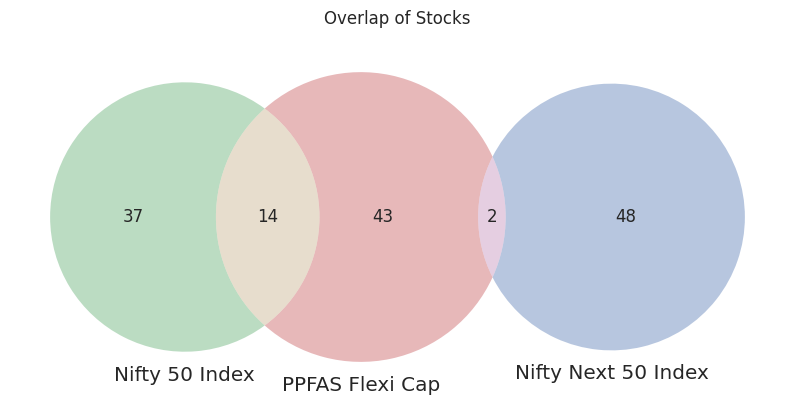

In [ ]:
# Create the Venn diagram with three sets
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
venn3([ppfas_stocks, n50_stocks, n_next50_stocks], set_labels=('PPFAS Flexi Cap', 'Nifty 50 Index', 'Nifty Next 50 Index'))
plt.title('Overlap of Stocks')
plt.show()


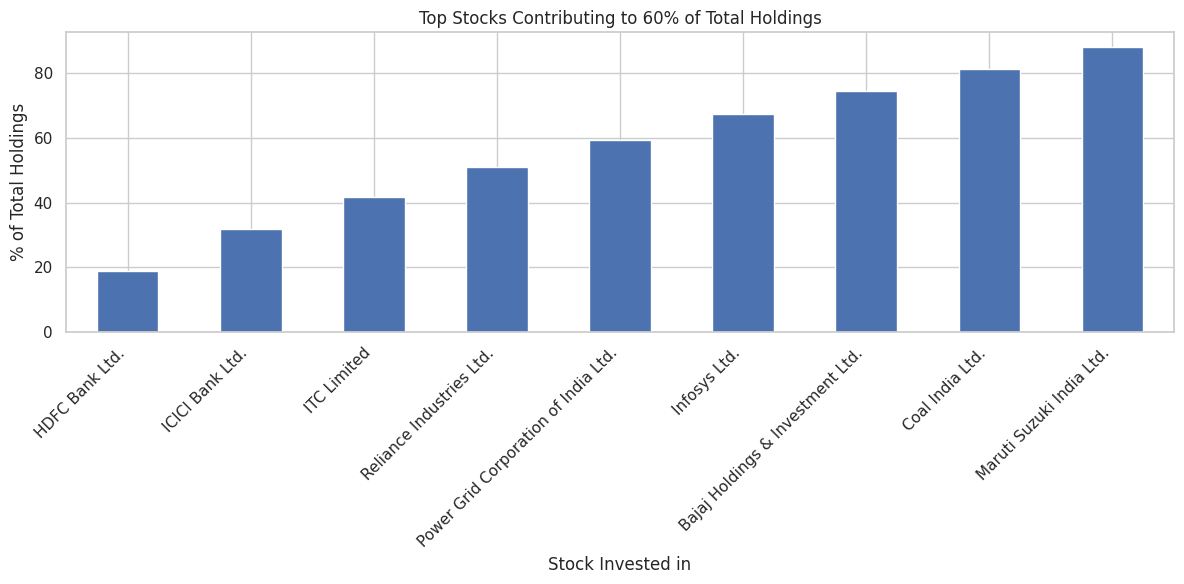

In [ ]:
# Concatenate the three DataFrames
combined_df = pd.concat([N50_Index, PPFAS_FC, N_Next_50_Index])

# Group by 'Stock Invested in' and sum '% of Total Holdings'
grouped_df = combined_df.groupby('Stock Invested in')['% of Total Holdings'].sum().sort_values(ascending=False)

# Calculate cumulative sum of holdings
cumulative_holdings = grouped_df.cumsum()

# Find stocks that make up 60% of total holdings
top_stocks = cumulative_holdings[cumulative_holdings <= 90]

# Create bar chart
plt.figure(figsize=(12, 6))
top_stocks.plot(kind='bar')
plt.xlabel('Stock Invested in')
plt.ylabel('% of Total Holdings')
plt.title('Top Stocks Contributing to 60% of Total Holdings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
